# Pre-Trained Models

A pre-trained model is a saved convolutional network that has been previously trained on a large-scale computer vision task, such as image classification or object detection. If the original dataset is sufficiently large and diverse, the convolutional backbone of the pre-trained network can be repurposed to extract features (from images) that transfer well to similar tasks, even when the new tasks involve completely different classes or objects. Such portability of learned features is the key advantage of deep learning over traditional learning methods, making it highly effective in data-limited scenarios.

TorchVision provides a collection of pre-trained models that can be used standalone or for transfer learning. The available models address different tasks, such as image classification, object detection, segmentation, person keypoint detection, optical flow, etc. In this tutorial, we will explore how to download and make predictions with some of these pre-trained models.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

## Getting Started

The module [`torchvision.models`](https://pytorch.org/vision/stable/models.html) provides a simple way to instantiate predefined networks and download pre-trained weights. The API allows loading different pre-trained weights on the same model, keeps track of meta-data such as the classification labels, and includes the preprocessing transforms necessary to prepare the input data for the models. In the following, we will review the basic workflow for using pre-trained models.

### Cache directory

TorchVision offers pre-trained weights for every provided architecture. Instancing a pre-trained model will download its weights from [PyTorch Hub](https://pytorch.org/docs/stable/hub.html) to a cache directory. By default, this directory is set to `<hub_dir>/checkpoints`, where `<hub_dir>` is the directory returned by `torch.hub.get_dir()`. Let's check the cache directory on our system.

In [2]:
print('Hub directory:', torch.hub.get_dir())

Hub directory: /Users/giovanni/.cache/torch/hub


There are two ways to change the Hub directory.
- Set the environment variable `TORCH_HOME` to the desired directory.
- Call the function `torch.hub.set_dir()` with the desired directory as argument.

We will keep the default cache directory for this tutorial.

### Loading a pre-trained model

For each pre-trained model, TorchVision provides a method to instantiate such model with or without pre-trained weights. The method signature is as follows.

```python
torchvision.models.<model_name>(weights=<weights_option>)
```

Here, `<model_name>` is the name of a pre-trained model, and `<weights_option>` specifies the weights to be loaded (or `None` for randomly initialized weights). As a general rule, the pre-trained models are named in lower case (`resnet50`, `mobilenet_v3_large`, ...), and the weights are named in camel case with the suffix `_Weights` (`ResNet50_Weights`, `MobileNet_V3_Large_Weights`, ...). The names of available pre-trained models are listed by the function `torchvision.models.list_models()`.

For example, here is how to instantiate a ResNet-50 model with pre-trained weights.

In [3]:
weights = torchvision.models.ResNet50_Weights.DEFAULT

model = torchvision.models.resnet50(weights=weights)

### Using a pre-trained model

Before a pre-trained model can be used to make predictions, we must preprocess the input images (resize with the right resolution, rescale the values, etc). There is no standard way to do this as it depends on how a model was trained. It can vary across model families, variants or even weight versions. Using the correct preprocessing method is critical and failing to do so may lead to decreased accuracy or incorrect outputs.

All the necessary information for the inference transforms of each pre-trained model is provided on its weights documentation. To simplify inference, TorchVision bundles the necessary preprocessing transforms into each model weight. These are accessible via the `weight.transforms` attribute. Furthermore, some models use layers which have different training and evaluation behavior, such as batch normalization. To switch between these modes, we must use `model.train()` or `model.eval()` as appropriate. 

In [4]:
model.eval()

preprocess = weights.transforms()

We are now ready to make predictions with the pre-trained model.

## Classification

Image classification is a computer vision task that involves predicting the class of an image. TorchVision provides several [pre-trained models](https://pytorch.org/vision/stable/models.html#classification) that can be used for image classification. These models are trained on the ImageNet-1K dataset, which consists of 1.2 million images from 1000 classes. The table of all available classification weights can be found [here](https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights), along with their performance metrics.

### Loading a pre-trained model

Here is how to instantiate a pre-trained model for image classification. We need to load the pre-trained weights into the selected architecture, set the model to evaluation mode, and retrieve the preprocessing transforms from the weights.

In [5]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

weights = MobileNet_V3_Large_Weights.DEFAULT

classifier = mobilenet_v3_large(weights=weights)
classifier.eval()

preprocess = weights.transforms()

### Preparing test data

To demonstrate the model's prediction capabilities, we are going to download the test images of [Imagenette](https://pytorch.org/vision/stable/generated/torchvision.datasets.Imagenette.html) dataset, which is a subset of 10 easily classified classes from Imagenet (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute). The images come in three different resolutions (full, 320px, 160px).

In [6]:
from torchvision.datasets import Imagenette

test_ds = Imagenette('.data/Imagenette', split='val', download=True, size="160px")

print("Number of images:", len(test_ds))
print("Image size:", test_ds[0][0].size)

Number of images: 3925
Image size: (213, 160)


### Making predictions

Let's grab a batch of images from the test dataset, preprocess them, and make predictions with the pre-trained model. As usual with classification models, the output is a vector of class logits for each image. We can use the softmax function to convert these logits into probabilities.

In [7]:
torch.manual_seed(14)

# Random image indices
n = 4
idx = torch.randint(0, len(test_ds), (n,))

# Retrieve images and labels
images, labels = zip(*[test_ds[i] for i in idx])

# Preprocess and stack images
batch = torch.stack([preprocess(img) for img in images])

# Make predictions
preds = classifier(batch)

# Convert logits to probabilities
preds = torch.nn.functional.softmax(preds, dim=1)

Let's visualize the predictions generated by the model. We will display the top-5 predicted classes for each image. Note that the `weights.meta["categories"]` attribute contains the class labels of the dataset used to pre-train the model.

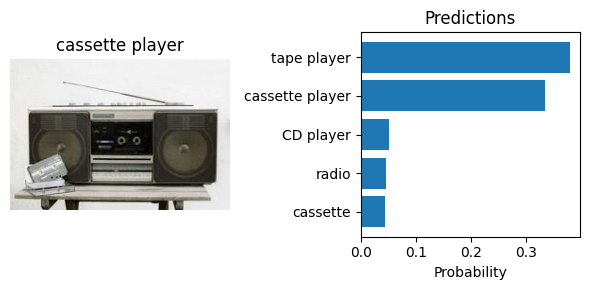

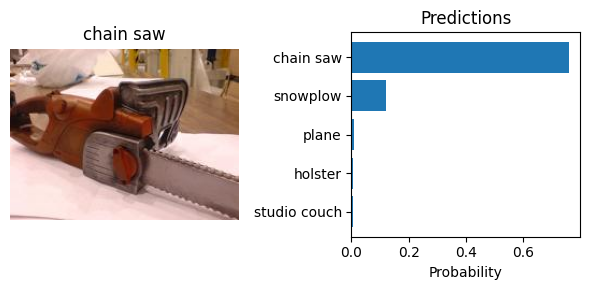

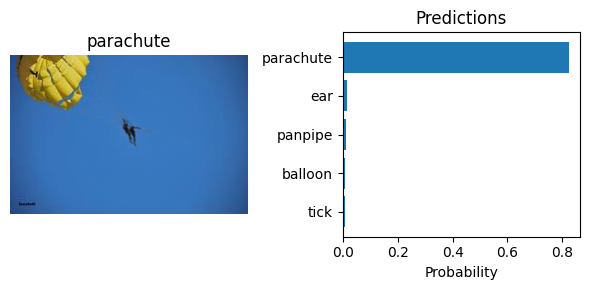

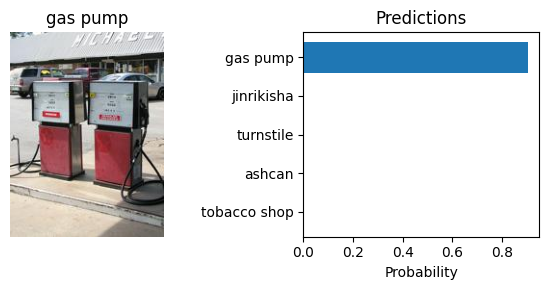

In [8]:
categories = weights.meta["categories"]

for i, (img, label) in enumerate(zip(images, labels)):
    plt.figure(figsize=(6, 3), tight_layout=True)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{test_ds.classes[label][0]}")

    p = preds[i].detach()
    top5 = torch.argsort(p, descending=True)[:5]
    top5_cats = [categories[i] for i in top5]
    top5_probs = p[top5]

    plt.subplot(1, 2, 2)
    plt.barh(top5_cats, top5_probs)
    plt.gca().invert_yaxis()
    plt.xlabel('Probability')
    plt.title('Predictions')
    plt.show()

## Object Detection

Object detection is a computer vision task that involves detecting and classifying objects in an image. TorchVision provides several [pre-trained models](https://pytorch.org/vision/stable/models.html#object-detection) that can be used for object detection. These models are trained on the COCO dataset, which consists of 80 classes. The table of all available object detection weights can be found [here](https://pytorch.org/vision/stable/models.html#table-of-all-available-object-detection-weights), along with their performance metrics.

### Loading a pre-trained model

Here is how to instantiate a pre-trained model for object detection. We need to load the pre-trained weights into the selected architecture, set the model to evaluation mode, and retrieve the preprocessing transforms from the weights.

In [9]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights

weights = FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT

detector = fasterrcnn_mobilenet_v3_large_fpn(weights=weights)
detector.eval()

preprocess = weights.transforms()

### Preparing test data

To demonstrate the model's prediction capabilities, we are going to download the test images of [Pascal Voc](https://pytorch.org/vision/stable/generated/torchvision.datasets.VOCDetection.htm) dataset. The dataset consists of 20 classes, including person, animals (bird, cat, cow, dog, horse, sheep), vehicles (aeroplane, bicycle, boat, bus, car, motorbike, train), and indoor (bottle, chair, dining table, potted plant, sofa, tv/monitor). 

In [10]:
from torchvision.datasets import VOCDetection

test_ds = VOCDetection('.data/voc', year='2007', image_set='test', download=True)

print("Number of images:", len(test_ds))
print("Image size:", test_ds[0][0].size)

Number of images: 4952
Image size: (353, 500)


### Making predictions

The input to the model is expected to be a list of 3D tensors, one for each image, in channel-first format (C, H, W). The values should be in the 0-1 range. The behavior of the model changes depending on if it is in training or evaluation mode. In evaluation mode, the model returns a list of dictionaries, one for each image, containing the following keys.

 - `boxes` - The predicted boxes for each detection, in (x1, y1, x2, y2) format.

 - `labels` - The predicted class labels for each detection.
 
 - `scores` - The scores for each detection.



In [11]:
torch.manual_seed(10)

# Random image indices
n = 4
idx = torch.randint(0, len(test_ds), (n,))

# Retrieve images and labels
images, labels = zip(*[test_ds[i] for i in idx])

# Preprocess images
batch = [preprocess(img) for img in images]

# Make predictions
preds = detector(batch)

Let's visualize the predictions generated by the model. For each image, we will only display the boxes with a confidence score greater than 0.5.

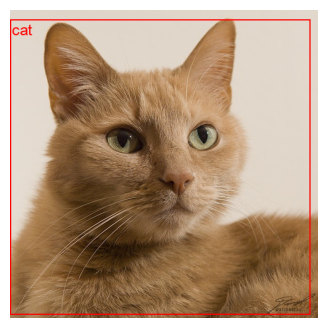

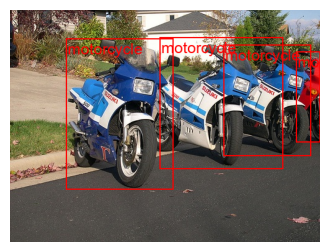

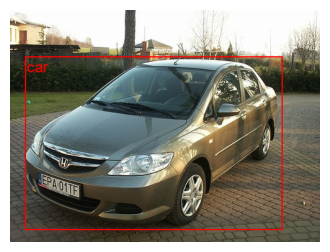

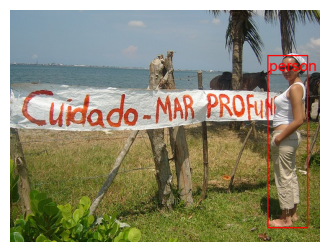

In [18]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.v2.functional import to_image

thresh = 0.5

for pil_image, prediction in zip(images, preds):

    # Reject detections with low scores
    scores = prediction["scores"]
    accepted = scores > thresh
    labels = prediction["labels"][accepted]
    class_names = [weights.meta["categories"][i] for i in labels]
    boxes = prediction["boxes"][accepted]

    # Draw bounding boxes
    tensor_image = to_image(pil_image)
    image_boxes = draw_bounding_boxes(tensor_image, boxes=boxes, labels=class_names, width=2, font="Arial", font_size=25, colors="red")

    plt.figure(figsize=(4,4))
    plt.imshow(image_boxes.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

## Summary

In this tutorial, we learned how to download and make predictions with pre-trained models using TorchVision. We explored the basic workflow for using pre-trained models for image classification and object detection tasks. We also discussed the importance of preprocessing input data and how to visualize the predictions generated by the models.